In [9]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='a586d82d-1fb0-43e0-950e-9c5e0581eb26', project_access_token='REMOVED')
pc = project.project_context

from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space({'token':'REMOVED'})


aclImdb  imdb.zip  __MACOSX


In [10]:
!pip install catboost
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 19.7 MB/s eta 0:00:0000:0100:01


In [11]:
import pandas as pd
import numpy as np
import os, sys, io
import numpy as np
from io import BytesIO, StringIO
from project_lib import Project

import re, math, os

from collections import Counter, defaultdict

from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import catboost as ctb
#import lightgbm as lgb

from sklearn.metrics import accuracy_score, f1_score
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Zbierzmy poszczególne recenzje szkoleń w listę łańcuchów, jeden łańcuch na
recenzję. Zbieramy również etykiety recenzji (pozytywne/negatywne) do listy labels.

In [12]:
import os, types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_a205bd0ef67d4e43a20f54571521aa41 = 'https://s3-api.us-geo.objectstorage.softlayer.net'
else:
    endpoint_a205bd0ef67d4e43a20f54571521aa41 = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'

client_a205bd0ef67d4e43a20f54571521aa41 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='REMOVED',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_a205bd0ef67d4e43a20f54571521aa41)
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_4 = client_a205bd0ef67d4e43a20f54571521aa41.get_object(Bucket='2020l-donotdelete-pr-iya5gjhbhguf6w', Key='aclImdb.zip')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_4, "__iter__"): streaming_body_4.__iter__ = types.MethodType( __iter__, streaming_body_4 ) 
    
data = streaming_body_4._raw_stream  

In [13]:
with open("imdb.zip", "wb") as outfile:
    # Copy the BytesIO stream to the output file
    outfile.write(data.read())

In [14]:
import zipfile
def get_zip(file_name):
    '''
    file_name = Name of zip file you want to download from object storage
    '''
    try:
        z = zipfile.ZipFile(file_name)
        z.extractall()
    except Exception as e:
        print(Exception,e)
    else:
        print('Files downloaded successfully')

In [15]:
get_zip('imdb.zip')

Files downloaded successfully


In [16]:
imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [17]:
# create and load df from lists 'labels' and 'texts'
df = pd.DataFrame(columns=['labels', 'texts'])
df['labels'] = labels
df['texts'] = texts

In [18]:
df

,labels,texts
0,0,I am a big fan of low budget horror movies lik...
1,0,I know that in this episode there's other stuf...
2,0,Whoever wrote the script for this movie does n...
3,0,"""You're not going to shoot those little creatu..."
4,0,It seems that several of the people who have r...
...,...,...
24995,1,Why did I enjoy the show to the last episode? ...
24996,1,Though I liked On the Town better I really lik...
24997,1,Although this was obviously a low-budget produ...
24998,1,"Not only do the storylines in ""The Sopranos"" e..."


In [19]:
# mieszanie
df = df.sample(frac = 1.0, random_state=33)

In [20]:
!ls

aclImdb  imdb.zip  __MACOSX


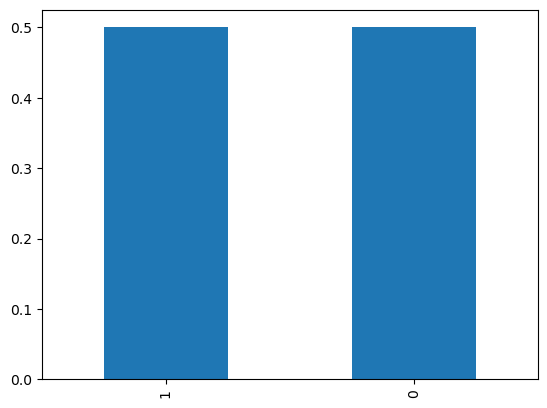

In [21]:
# rozkład etykiet w zbiorze treningowym
df['labels'].value_counts(normalize=True).plot(kind='bar');

In [22]:
# lekka normalizacja
df['texts_norm'] = df['texts'].str.lower()

In [23]:
project.save_data('imdb_data_train.csv', df.to_csv(index=False), overwrite=True)

{'file_name': 'imdb_data_train.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'imdbclassification-donotdelete-pr-lwfp7v5evaony8',
 'asset_id': '4080ef18-7009-4871-a470-b33ed9943c2c'}

In [24]:
test_initial_1 = df.iloc[0]['texts_norm']
test_initial_1

'one of the best documentaries released in recent years. some points...<br /><br />1. hugo chavez was elected venezuela\'s president in 1998, his support largely coming from the poorer regions of venezuela.<br /><br />2. in 2002, a coup briefly deposed chavez. at the time, irish filmmakers kim bartley and donnacha o\'briain were in caracas, shooting a documentary about chavez for british television. their film deconstructs the coup and its aftermath, and electrifyingly records history unfolding on-the-spot, outside and inside the presidential palace.<br /><br />3. chavez aimed to free venezuela from the free-market policies imposed on it by the us. though venezuela\'s oil was already state-owned, it was run for private benefit by executives who chavez wished to replace.<br /><br />4. despite being the world\'s fourth largest oil supplier, venezuela remains swamped by poverty, its resources literally sucked away by foreign multinational corporations.<br /><br />5. the documentary begins

In [25]:
df.iloc[0]['texts']

'One of the best documentaries released in recent years. Some points...<br /><br />1. Hugo Chavez was elected Venezuela\'s president in 1998, his support largely coming from the poorer regions of Venezuela.<br /><br />2. In 2002, a coup briefly deposed Chavez. At the time, Irish filmmakers Kim Bartley and Donnacha O\'Briain were in Caracas, shooting a documentary about Chavez for British television. Their film deconstructs the coup and its aftermath, and electrifyingly records history unfolding on-the-spot, outside and inside the presidential palace.<br /><br />3. Chavez aimed to free Venezuela from the free-market policies imposed on it by the US. Though Venezuela\'s oil was already state-owned, it was run for private benefit by executives who Chavez wished to replace.<br /><br />4. Despite being the world\'s fourth largest oil supplier, Venezuela remains swamped by poverty, its resources literally sucked away by foreign multinational corporations.<br /><br />5. The documentary begins

In [26]:
# tokenizacja
tokens_set = set()
df['texts_norm'].str.split(" ").map(tokens_set.update)

len(tokens_set)

252192

In [27]:
# najczęściej występujące tokeny? -> Counter(tokens_set).most_common()
cntr = Counter()
df["texts_norm"].str.split(" ").map(cntr.update)
cntr.most_common(n=5)

[('the', 322174),
 ('a', 159949),
 ('and', 158556),
 ('of', 144459),
 ('to', 133965)]

In [28]:
def get_df_topn(text, topn, counter_tokens):
    top_tokens = [ x[0] for x in counter_tokens.most_common(n=topn) ]
    
    def check_top_n(sent_tokens):
        return [int(token in sent_tokens) for token in top_tokens]

    df_topn = text.str.split(" ").map(set).map(check_top_n).apply(pd.Series)
    df_topn.columns = top_tokens

    return df_topn

In [29]:
df_top50 = get_df_topn(df["texts_norm"], topn=50, counter_tokens=cntr)

df_top50

,the,a,and,of,to,is,in,i,this,that,...,her,about,it's,some,if,out,what,very,when,more
17797,1,1,1,1,1,1,1,0,1,1,...,0,1,0,1,0,0,0,0,1,0
6458,1,1,1,1,1,1,1,1,1,0,...,0,1,0,0,1,1,0,0,1,0
14478,1,1,1,1,0,1,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
14825,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,1,0,0,0
7523,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,0,0
578,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
5848,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,0,0,1,0,0,0
2439,1,1,1,1,1,1,1,0,1,1,...,0,0,0,1,0,0,0,0,0,0


In [30]:
# Dla ilu opinii nie mozna określić kategorii na podstawie wybranej liczby tokenów? 
result = []
for topn in [1, 5, 10, 20, 50, 100]:
    df_topn = get_df_topn( df['texts_norm'], topn=topn, counter_tokens=cntr)
    missing = df_topn[ df_topn.sum(axis=1) == 0 ].shape
    
    result.append((topn, missing))
    print('n={}, missing={}'.format(topn, missing))

n=1, missing=(229, 1)
n=5, missing=(8, 5)
n=10, missing=(4, 10)
n=20, missing=(2, 20)
n=50, missing=(0, 50)
n=100, missing=(0, 100)


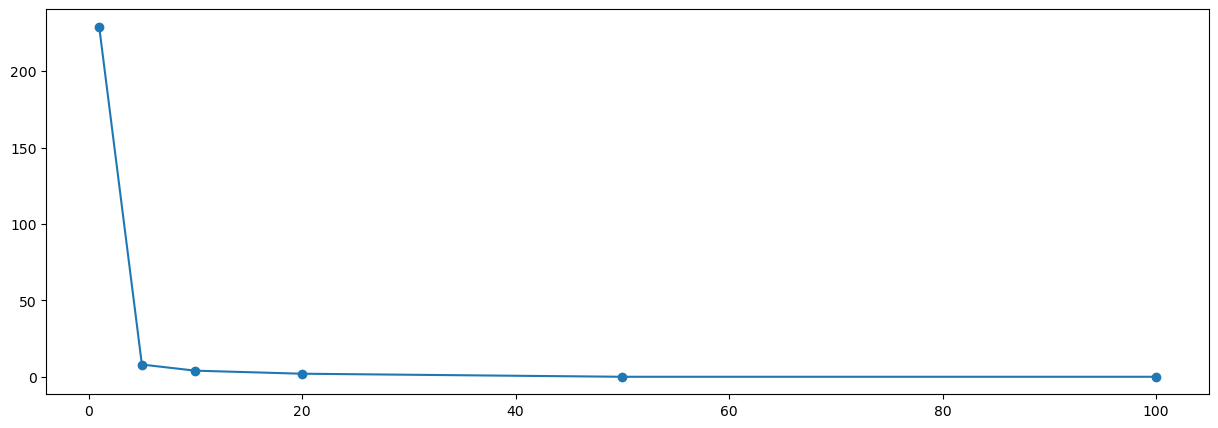

In [31]:
x = [i[0] for i in result]
y = [i[1][0] for i in result]

plt.figure(figsize=(15, 5))
plt.plot( x, y, 'o-' );

## <span style="color:red">2. Wstęp do modelowania: *bag of words*</span>

### <span style="color:magenta">2.1 Podejście oparte o tokenizację manualną</span>

#### <span style="color:#ffff00">Sprawdzenie na danych testowych</span>

In [32]:
imdb_dir = './aclImdb'
test_dir = os.path.join(imdb_dir, 'test')

labels_test = []
texts_test = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts_test.append(f.read())
            f.close()
            if label_type == 'neg':
                labels_test.append(0)
            else:
                labels_test.append(1)

In [33]:
# del(df_test)

In [34]:
df_test = pd.DataFrame(columns=['labels', 'texts'])
df_test['labels']=labels_test
df_test['texts']=texts_test

In [35]:
df_test

,labels,texts
0,0,As one who loves films that appeal to intellec...
1,0,I think there's a reason this film never came ...
2,0,"I say Ben Johnson and my fellow Canadians say,..."
3,0,"Yes, the movie was that boring and insipid. af..."
4,0,well I'd probably agree with all the bad comme...
...,...,...
24995,1,a mesmerizing film that certainly keeps your a...
24996,1,"Although ""They Died with their Boots On"" is no..."
24997,1,"This is, by far, the best movie I've seen in a..."
24998,1,<br /><br />What more can you ask for? A great...


In [48]:
df_test = df_test.sample(frac = 1.0, random_state=33)
df_test['texts_norm'] = df_test['texts'].str.lower()

In [49]:
project.save_data('imdb_data_test.csv', df.to_csv(index=False), overwrite=True)

{'file_name': 'imdb_data_test.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'imdbclassification-donotdelete-pr-lwfp7v5evaony8',
 'asset_id': 'ce557a4e-b899-4f17-be7d-930e2fa524cf'}

In [31]:
df_test.iloc[:25000]

,labels,texts,texts_norm
17797,1,A film that deserved theatrical release. This ...,a film that deserved theatrical release. this ...
6458,0,This filmmaker wanted to make a movie without ...,this filmmaker wanted to make a movie without ...
14478,1,A competent comedy that delivers the laughs fo...,a competent comedy that delivers the laughs fo...
14825,1,Over the years some of them most enjoyable fil...,over the years some of them most enjoyable fil...
7523,0,The only reason to see this film is Sung Hi Le...,the only reason to see this film is sung hi le...
...,...,...,...
57,0,"When naïve young Eddie Hatch, a window dresser...","when naïve young eddie hatch, a window dresser..."
578,0,I've read the book 'Scarlett' and was expectin...,i've read the book 'scarlett' and was expectin...
5848,0,I have seen nearly all the films of Kurosawa a...,i have seen nearly all the films of kurosawa a...
2439,0,A wonderful semi-humorous homage to Expression...,a wonderful semi-humorous homage to expression...


In [32]:
#przykładowa opinia
df_test.iloc[4]['texts_norm']

'the only reason to see this film is sung hi lee, the stunning model/actress from korea who plays "muka laka miki" (give me a break) in this otherwise crappy movie. <br /><br />she is given a fairly substantial part in this film and seems to handle it well, though none of the parts is really interesting or well written. even for a national lampoon\'s movie, it\'s really stupid. stupid humor is one thing, but just stupid is another. i may have laughed once, and that was probably just me being polite.<br /><br />warning: watching this movie may be bad for your health on two counts: 1) it, like, totally sucks. 2) sung hi lee is so freaking gorgeous she just might blow your brains out of the back of your head upon first sight.<br /><br />so don\'t say i didn\'t warn you...'

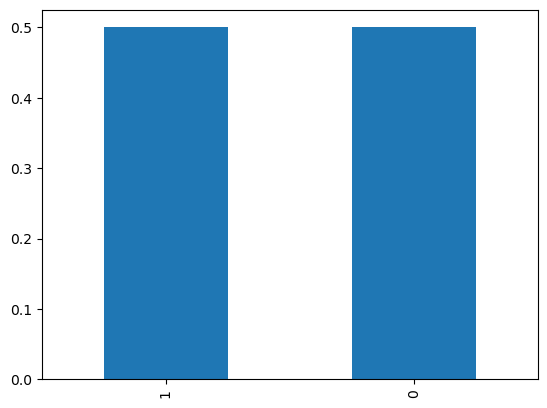

In [33]:
df_test.iloc[:25000]['labels'].value_counts(normalize=True).plot(kind='bar');

In [90]:
# y = df_test.iloc[:25000]['labels']
y1 = df_test.iloc[:25000]['labels'].values.tolist()

In [91]:
# wybieramy apriori 50 jako liczbę wymiarów, które wykorzystamy do klasyfikacji
X = get_df_topn( df['texts_norm'], 50, counter_tokens=cntr).values


# y = (df['target'] == 'spam').astype(np.int8).values
y = df['labels'].factorize()[0]

Odrobina przeglądu danych:

In [78]:
X

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]])

In [38]:
len(X[0])

50

In [82]:
def get_models2(use_dummy):
    
    models = [('dummy', DummyClassifier(strategy='stratified'))] if use_dummy else []
    
    models += [
        ('catboost', ctb.CatBoostClassifier(n_estimators=50, max_depth=5, random_state=0, verbose=0)),
        ('xgboost', xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)),
        ('LogisticRegression', LogisticRegression(random_state=0)),
        ('RandomForest', RandomForestClassifier(max_depth=5, random_state=0))
    ] 
    return models

In [83]:
def run_models2(X, y, use_dummy=True, scoring='accuracy', plot_result=False, show_confusion_matrix=True):
    result = []
    #cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    num_cols = 5
    if show_confusion_matrix:
        fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(15,10))


    for it, (model_name, model) in enumerate(get_models2(use_dummy)):
        clf = model
        clf.fit(X,y)
        y_pred = clf.predict(X)
        score = accuracy_score(y, y_pred)
        print("model={}, accuracy={}".format(model_name, score))

        if show_confusion_matrix:
            ax = axes[it]
            disp = ConfusionMatrixDisplay.from_predictions(y,y_pred,ax=ax,colorbar=None)
            disp.ax_.set_title('model: {}'.format(model_name))

model=dummy, accuracy=0.496
model=catboost, accuracy=0.66348
model=xgboost, accuracy=0.69864
model=LogisticRegression, accuracy=0.61944
model=RandomForest, accuracy=0.61872


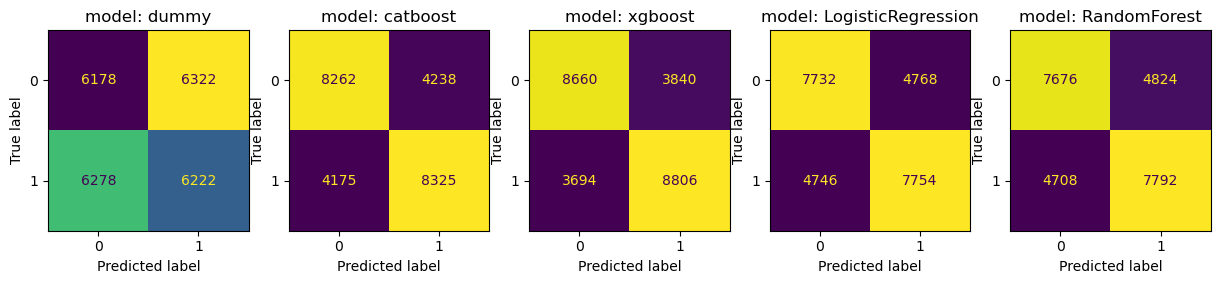

In [94]:
run_models2(X,y)

In [95]:
# Wybieramy xgboost bo jest najlepszy
xgboost_clf = xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)
xgboost_clf.fit(X,y)

y_pred = xgboost_clf.predict(X)
accuracy_score(y, y_pred)

0.69864

In [96]:
X_test = get_df_topn( df_test['texts_norm'], 50, counter_tokens=cntr).values
X_test

array([[1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 1, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 1, 0]])

In [101]:
xgboost_clf = xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)
xgboost_clf.fit(X,y1)

y_pred = xgboost_clf.predict(X_test)
accuracy_score(df_test['labels'], y_pred)

0.60956

In [85]:
rf_clf = RandomForestClassifier(max_depth=5, random_state=0)
rf_clf.fit(X,y1)

y_pred = rf_clf.predict(X_test)
accuracy_score(df_test['labels'], y_pred)

0.604

In [43]:
len(y_pred)

25000

In [44]:
def predicta(text):
    # del dft
    # text = purify(text)
    dft = pd.DataFrame({'texts':[text]})
    dft['texts_norm'] = dft['texts'].str.lower()
    return xgboost_clf.predict(get_df_topn(dft["texts_norm"], 50, counter_tokens=cntr).values)[0]
    # return dft

In [45]:
cat=["negative", "positive"]

In [46]:
cat[predicta(df_test.iloc[0]['texts_norm'])]

'negative'

### <span style="color:magenta">2.2 Tokenizacja wbudowana w scikit-learn</span>

In [47]:
vectorizer = CountVectorizer(binary=True, max_features=50)
XV = vectorizer.fit_transform(df['texts'])
vectorizer.get_feature_names_out()

array(['about', 'all', 'an', 'and', 'are', 'as', 'at', 'be', 'br', 'but',
       'by', 'can', 'film', 'for', 'from', 'good', 'has', 'have', 'he',
       'his', 'if', 'in', 'is', 'it', 'just', 'like', 'more', 'movie',
       'not', 'of', 'on', 'one', 'or', 'out', 'so', 'some', 'that', 'the',
       'there', 'they', 'this', 'time', 'to', 'up', 'was', 'what', 'when',
       'who', 'with', 'you'], dtype=object)

In [48]:
XV

<25000x50 sparse matrix of type '<class 'numpy.int64'>'
	with 712336 stored elements in Compressed Sparse Row format>

model=dummy, accuracy=0.4944
model=catboost, accuracy=0.66204
model=xgboost, accuracy=0.69272
model=LogisticRegression, accuracy=0.61552


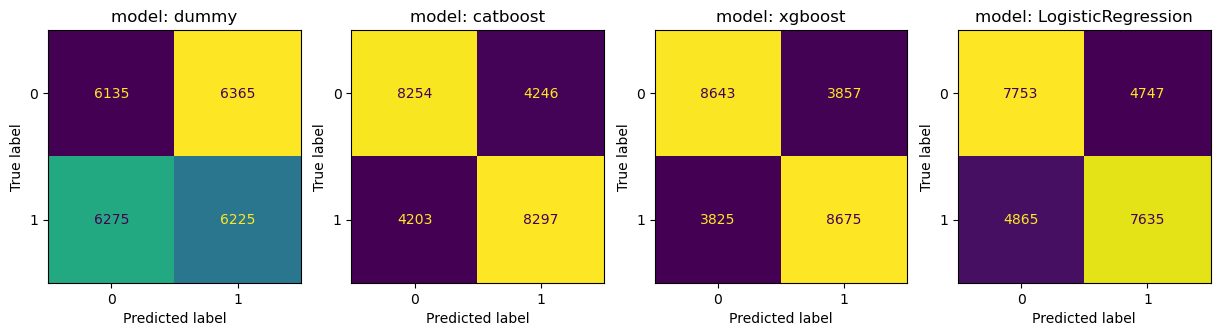

In [49]:
run_models2(XV.toarray(), y1)

In [50]:
# I znowu bierzemy do docelowej funkcji predictv xgboost bo jest najlepszy
xgboost_clf_v = xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)
xgboost_clf_v.fit(XV.toarray(),y1)
y_pred_v = xgboost_clf_v.predict(XV.toarray())
accuracy_score(y1, y_pred_v)

0.69272

In [51]:
def predictv(text):
    #del dft
    return xgboost_clf_v.predict(vectorizer.transform([text]).toarray())[0]

In [52]:
cat[predictv(df_test.iloc[0]['texts'])]

'negative'

### <span style="color:magenta">2.3 Tokenizacja 'niejednorodna' oparta o TfidfVectorizer (również scikit-learn)</span>

In [53]:
vectorizer = TfidfVectorizer(binary=True, max_features=50)
XT = vectorizer.fit_transform(df['texts'])

model=dummy, accuracy=0.50156
model=catboost, accuracy=0.66144
model=xgboost, accuracy=0.71796
model=LogisticRegression, accuracy=0.6154


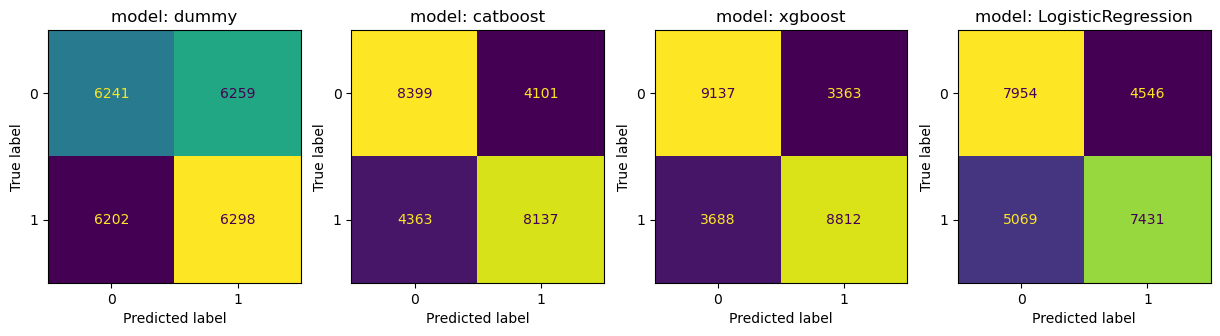

In [54]:
run_models2(XT.toarray(), y1)

In [55]:
# I znowu ... wygrywa xgboost 
xgboost_clf_tfidf = xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=0)
xgboost_clf_tfidf.fit(XT.toarray(),y1)
y_pred_tfidf = xgboost_clf_tfidf.predict(XT.toarray())
accuracy_score(y1, y_pred_tfidf)

0.71796

In [56]:
def predicttfidf(text):
    return xgboost_clf_tfidf.predict(vectorizer.transform([text]).toarray())[0]

In [60]:
cat[predicttfidf(df_test.iloc[0]['texts'])]

'negative'

In [4]:
api_key = 'REMOVED'
location = 'eu-de'

In [5]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

In [6]:
!pip install -U ibm-watson-machine-learning | tail -n 1
!pip install wget | tail -n 1
!pip install plotly | tail -n 1

In [7]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

In [ ]:
client.spaces.list(limit=10)

In [9]:
space_id = '40c34b8b-cbce-4422-b3ba-cf0c9714b688'

In [10]:
client.set.default_space(space_id)

'SUCCESS'

In [ ]:
cos_credentials = client.spaces.get_details(space_id=space_id)['entity']['storage']['properties']
cos_credentials

In [18]:
datasource_name = 'bluemixcloudobjectstorage'
bucketname = cos_credentials['bucket_name']

conn_meta_props= {
    client.connections.ConfigurationMetaNames.NAME: f"Connection to Database - {datasource_name} ",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: client.connections.get_datasource_type_uid_by_name(datasource_name),
    client.connections.ConfigurationMetaNames.DESCRIPTION: "Connection to external Database",
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        'bucket': bucketname,
        'access_key': cos_credentials['credentials']['editor']['access_key_id'],
        'secret_key': cos_credentials['credentials']['editor']['secret_access_key'],
        'iam_url': 'https://iam.cloud.ibm.com/identity/token',
        'url': cos_credentials['endpoint_url']
    }
}

conn_details = client.connections.create(meta_props=conn_meta_props)

Creating connections...
SUCCESS


In [19]:
connection_id = client.connections.get_uid(conn_details)

In [27]:
filename = 'aclImdb'

In [28]:
from ibm_watson_machine_learning.helpers import DataConnection, S3Location

data_connections = []
data_connection = DataConnection(
        connection_asset_id=connection_id,
        location=S3Location(bucket=cos_credentials['bucket_name'],
                            path=filename)
    )

data_connection.set_client(client)
data_connection.write(data=filename, remote_name=filename)
data_connections.append(data_connection)

IsADirectoryError: [Errno 21] Is a directory: 'aclImdb'

In [26]:
!ls

aclImdb  imdb.zip  __MACOSX


In [ ]:
from ibm_watson_machine_learning.experiment import AutoAI
from ibm_watson_machine_learning.utils.autoai.enums import TimeseriesAnomalyPredictionPipelineTypes


experiment = AutoAI(wml_credentials, space_id=space_id)

pipeline_optimizer = experiment.optimizer(
            name="IMDB reviews classification",
            prediction_type=AutoAI.PredictionType.CLASSIFICATION,
            timestamp_column_name='date',
            feature_columns=['industry_a_usage'],
            pipeline_types=[TimeseriesAnomalyPredictionPipelineTypes.PointwiseBoundedBATS,
                           TimeseriesAnomalyPredictionPipelineTypes.PointwiseBoundedBATSForceUpdate,
                           TimeseriesAnomalyPredictionPipelineTypes.PointwiseBoundedHoltWintersAdditive,
                           TimeseriesAnomalyPredictionPipelineTypes.WindowLOF,
                           TimeseriesAnomalyPredictionPipelineTypes.WindowNN,
                           TimeseriesAnomalyPredictionPipelineTypes.WindowPCA]
)

In [44]:
array_of_input_fields = ["texts", "texts_norm"]
array_of_values_to_be_scored = [
    'Keep in mind I\'m a fan of the genre but have only recently seen this film for the first time. How I\'ve overlooked it all this time is a wonder to me. To me this is a better film then the much lauded "High Noon". It\'s a great western with excellent acting and a great story. The DVD is in beautifull black and white with outstanding cinematography. If you like westerns or James Stewart this film is not to be missed.',
    'keep in mind i\'m a fan of the genre but have only recently seen this film for the first time. how i\'ve overlooked it all this time is a wonder to me. to me this is a better film then the much lauded "high noon". it\'s a great western with excellent acting and a great story. the dvd is in beautifull black and white with outstanding cinematography. if you like westerns or james stewart this film is not to be missed.',                                 
]

In [45]:
import requests

# NOTE: you must manually set API_KEY below using information retrieved from your IBM Cloud account.
API_KEY = "REMOVED" 
token_response = requests.post('https://iam.cloud.ibm.com/identity/token', data={"apikey":
 API_KEY, "grant_type": 'urn:ibm:params:oauth:grant-type:apikey'})
mltoken = token_response.json()["access_token"]

header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_scoring = {"input_data": [{"fields": [array_of_input_fields], "values": [array_of_values_to_be_scored]}]}

response_scoring = requests.post('https://eu-de.ml.cloud.ibm.com/ml/v4/deployments/imdbclassifier/predictions?version=2023-05-09', json=payload_scoring,
 headers={'Authorization': 'Bearer ' + mltoken})
print("Scoring response")
print(response_scoring.json())

Scoring response
{'predictions': [{'fields': ['prediction', 'probability'], 'values': [[1, [0.11279898881912231, 0.8872010111808777]]]}]}
